# Experiment with different distance metrics & clustering algorithms

In [1]:
import sys
import logging

nblog = open("TMS_result.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [2]:
import time
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.cluster import normalized_mutual_info_score

import data_loader
import pp

import scanpy as sc


%load_ext autoreload
%autoreload 2

## Data Loading

In [4]:
# Local path 
DATA_PATH = '/projects/zhanglab/sc_data/TMS_2020/tabula-muris-senis-facs-official-raw-obj.h5ad'

# Loading raw data
adata = data_loader.load_annData(DATA_PATH)    
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 110824 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

## Pick a tissue

In [5]:

adata = adata[adata.obs['tissue'] == 'Heart', :]
adata

View of AnnData object with n_obs × n_vars = 9669 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

## Data Preprocessing

In [6]:
# Preprocess data # pp.preprocess(adata)
pp.filter_cell(adata, min_genes = 500)
pp.filter_gene(adata, min_cells = 500)
pp.filter_mt_genes(adata)
pp.normalize_size(adata, target_sum = 1e4)
pp.normalize_log(adata)
pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
adata

/home/chunchua/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/chunchua/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 9669 × 10076
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Clustering

### True labels

true labels are based on “cell_ontology_class”

In [7]:

from collections import Counter

def encode(celltypes):
    labels_dict = {}
    labels = []
    cur = 0

    for c in celltypes:
        if c not in labels_dict:
            labels_dict[c] = cur
            cur += 1 # increase smallest index
        labels.append(labels_dict[c])
    return labels, labels_dict


celltypes = pd.Series(adata.obs['cell_ontology_class'])
labels, labels_dict = encode(celltypes)

adata.obs['true_label'] = labels
labels_dict

{'B cell': 0,
 'fibroblast of cardiac tissue': 1,
 'endothelial cell of coronary artery': 2,
 'monocyte': 3,
 'macrophage': 4,
 'endocardial cell': 5,
 'valve cell': 6,
 'atrial myocyte': 7,
 'T cell': 8,
 'smooth muscle cell': 9,
 'ventricular myocyte': 10}

### Leidon

/home/chunchua/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/chunchua/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


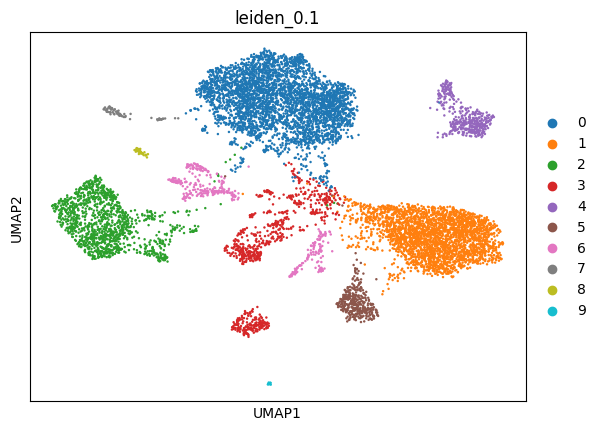

In [9]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')
# KNN
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs=40)
sc.tl.leiden(adata, resolution = 0.1, key_added  = 'leiden_0.1')
# UMAP embedding based on KNN
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['leiden_0.1'])

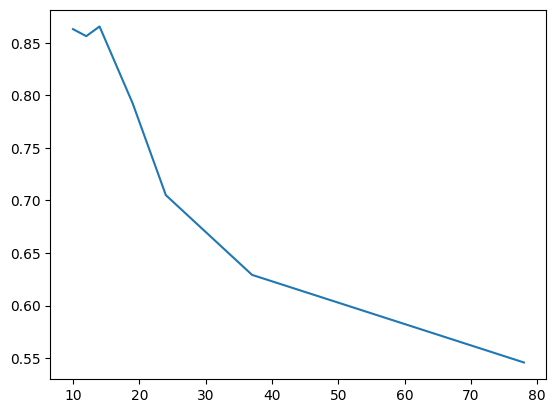

In [41]:
import matplotlib.pyplot as plt
from collections import Counter

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs=40)

num_clusters = []
nmi_list = []
for r in [0.1, 0.2, 0.25, 0.5, 1, 2, 5]:
    sc.tl.leiden(adata, resolution = r, key_added  = 'leiden_'+str(r))

    num_clusters.append(len(Counter(adata.obs['leiden_'+str(r)]).keys()))
    nmi_list.append(normalized_mutual_info_score(adata.obs['true_label'], adata.obs['leiden_'+str(r)]))

plt.plot(num_clusters, nmi_list)

In [42]:
print('ground truth #labels: ', len(Counter(adata.obs['true_label'])))

for i in range(len(num_clusters)):
    print(f'number of cluster = {num_clusters[i]}: {nmi_list[i]}')

ground truth #labels:  11
number of cluster = 10: 0.8630408188302275
number of cluster = 12: 0.8563673789695915
number of cluster = 14: 0.8655701470778665
number of cluster = 19: 0.7923650790976029
number of cluster = 24: 0.7050592693523338
number of cluster = 37: 0.6291837281766296
number of cluster = 78: 0.545814720593356


### K-medoids

#### Clustering with different metrics

In [44]:
# from banditpam import KMedoids
# from sklearn.metrics.cluster import normalized_mutual_info_score 

# df_score = pd.DataFrame()
# df_score.index.name = 'k'

# for metric in ['L1', 'L2', 'inf', 'cos', 'manhattan']:

#     score_list = []
#     for k in range(1, 9):
#         clustering.cluster_banditpam(adata, n_medoids = k, metric = metric)
#         nmi = normalized_mutual_info_score(adata.obs['true_label'], adata.obs['kmed_'+metric])
#         score_list.append(nmi)
#     df_score[metric] = score_list

# df_score.index = range(1,9)
# df_score

#### Find best K

In [45]:
# import matplotlib.pyplot as plt
# colormap = plt.get_cmap('tab10')

# for i, metric in enumerate(['L1', 'L2', 'inf', 'cos']):
#     plt.plot(df_score.index, df_score[metric], label=metric, color=colormap(i))

# plt.title('NMI v.s. number of K')
# plt.xlabel('K')
# plt.ylabel('NMI')
# plt.legend()
# plt.show()

#### Visualize clustering result 

In [13]:
# True labels are stored in adata.obs
# import warnings
# warnings.filterwarnings('ignore')
# sc.pl.umap(adata, color=['leiden', 'kmed_L1' , 'kmed_L2' , 'kmed_inf', 'kmed_cos', 'kmed_manhattan' ,'true_label'])

#### Benchmarking clustering

use NMI

In [3]:
from collections import Counter

def encode(celltypes):
    labels_dict = {}
    labels = []
    cur = 0

    for c in celltypes:
        if c not in labels_dict:
            labels_dict[c] = cur
            cur += 1 # increase smallest index
        labels.append(labels_dict[c])
    return labels, labels_dict


In [4]:
# load data
DATA_PATH = '/projects/zhanglab/sc_data/TMS_2020/tabula-muris-senis-facs-official-raw-obj.h5ad'
adata = data_loader.load_annData(DATA_PATH)    
adata.var_names_make_unique()

## label
celltypes = pd.Series(adata.obs['cell_ontology_class'])
labels, labels_dict = encode(celltypes)
adata.obs['true_label'] = labels

# feature selection
adata = adata[adata.obs['tissue'] == 'Heart', :]
pp.filter_cell(adata, min_genes = 500)
pp.filter_gene(adata, min_cells = 500)
pp.filter_mt_genes(adata)
pp.normalize_size(adata, target_sum = 1e4)
pp.normalize_log(adata)

## HVG v.s. no selection
adata_hvg = adata.copy()
pp.highly_variable_genes(adata_hvg, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

## PCA
start_time = time.time()
sc.tl.pca(adata_hvg, svd_solver='arpack')
pca_time_hvg = time.time() - start_time

start_time = time.time()
sc.tl.pca(adata, svd_solver='arpack')
pca_time = time.time() - start_time


/home/chunchua/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/chunchua/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [ ]:
from collections import defaultdict
from banditpam import KMedoids
import time

metric_dict = {
    'leiden': ['l1', 'l2', 'chebyshev', 'cosine'],
    'banditpam': ['L1', 'L2', 'inf', 'cos'],
}
feature_dict = {
    'leiden': ['PCA'],
    # 'leiden': ['PCA', 'raw'],
    'banditpam': ['raw']
}
results = pd.DataFrame(columns = ['algorithm', 'trial', 'HVG', 'feature', 'metric', 'NMI', 'time'])


n_trials = 10
for i in range(n_trials):
    print(f"[trial {i}]")

    for hasHVG in [True, False]:
        data = adata_hvg if hasHVG else adata
        data = sc.pp.subsample(data, fraction = 0.2, copy = True, random_state = i) 

        for alg in ['leiden', 'banditpam']:
            for metric in metric_dict[alg]:          # ['L1', 'L2', 'inf', 'cos']
                for feature in feature_dict[alg]:    # ['PCA', 'raw']
                    
                    
                    
                    run_time = - time.time()

                    # fit
                    if alg == 'leiden':
                        
                        if feature == 'PCA':
                            sc.pp.neighbors(data, n_neighbors = 10, n_pcs=40, metric = metric)
                        else:
                            sc.pp.neighbors(adata_hvg, n_neighbors = 10, n_pcs=0, use_rep = 'X', metric = metric)

                        sc.tl.leiden(data, resolution = 0.2, key_added = 'leiden_' + metric)

                        # add PCA run time if leiden
                        run_time = run_time + (pca_time_hvg if hasHVG else pca_time)
                        

                    else: # banditpam

                        kmed = KMedoids(n_medoids = 12, algorithm="BanditPAM")

                        if hasHVG:
                            kmed.fit(data.X[:, data.var['highly_variable']].toarray(), metric)
                        else:
                            kmed.fit(data.X.toarray(), metric)
                        
                        data.obs['banditpam_' + metric] = kmed.labels
                        data.obs['banditpam_' + metric] = data.obs['banditpam_' + metric].astype('category')


                    # add result to DataFrame
                    run_time += time.time()
                    nmi = normalized_mutual_info_score(data.obs['true_label'], data.obs[alg+'_' + metric])
                    results.loc[len(results.index)] = [alg, i, hasHVG, feature, metric, nmi, run_time]
                    print(f"\t NMI: {nmi} \t time: {run_time} \t", end='')
                    print(f'\t { "(use HVG)" if hasHVG else "(no HVG)"} {alg} - {metric} - {feature}')
                    
results.to_csv('results_0201.csv', index=False)  


[trial 0]
	 NMI: 0.8387530083522632 	 (time: 7.6107871532440186) 			 (use HVG) leiden  - l1 - PCA:
	 NMI: 0.8485629971279994 	 (time: 2.998690128326416) 			 (use HVG) leiden  - l2 - PCA:
	 NMI: 0.8520498905780743 	 (time: 1.571274757385254) 			 (use HVG) leiden  - chebyshev - PCA:
	 NMI: 0.8486057997118864 	 (time: 1.6188077926635742) 			 (use HVG) leiden  - cosine - PCA:
	 NMI: 0.25412881613435895 	 (time: 21.47741961479187) 			 (use HVG) banditpam  - L1 - raw:


In [159]:
data.obs

,FACS.selection,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,sex,subtissue,...,true_label,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden_l1,leiden_l2,leiden_chebyshev,leiden_cosine,BanditPAM_L1
index,,,,,,,,,,,,,,,,,,,,,
F15.B002428.3_38_F.1.1-1-1,nan,3m,F15.B002428.3_38_F.1.1,fibroblast of cardiac tissue,CL:0000057,fibroblast of cardiac tissue,facs,3_38_F,female,LA,...,8,2409,943382.0,0.0,0.0,0,0,0,0,0
H16_B001362_B009954_S184.mm10-plus-6-0,Viable,18m,H16_B001362,fibroblast of cardiac tissue,nan,fibroblast of cardiac tissue,facs,18_47_F,female,RA,...,8,4612,1122675.0,0.0,0.0,0,0,0,0,0
P20_B000809_B009956_S380.mm10-plus-6-0,Viable,18m,P20_B000809,endothelial cell of coronary artery,nan,coronary vascular endothelial cell,facs,18_46_F,female,LV,...,17,1693,878063.0,0.0,0.0,1,1,1,1,0
J16_B003791_S232_L004.mus-8-0-1,Viable,24m,J16_B003791,fibroblast of cardiac tissue,nan,fibroblast of cardiac tissue,facs,24_61_M,male,LV,...,8,3013,1490940.0,0.0,0.0,0,0,0,0,0
K12_B001360_B009953_S252.mm10-plus-6-0,Viable,18m,K12_B001360,fibroblast of cardiac tissue,nan,fibroblast of cardiac tissue,facs,18_46_F,female,RA,...,8,4130,1334738.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F4_B003857_S136_L004.mus-2-0-1,Viable,24m,F4_B003857,endothelial cell of coronary artery,nan,coronary vascular endothelial cell,facs,24_59_M,male,LV,...,17,1299,1693399.0,0.0,0.0,1,1,1,1,0
O14_B003229_S146_L004.mus-0-0-1,Viable,24m,O14_B003229,endothelial cell of coronary artery,nan,coronary vascular endothelial cell,facs,24_60_M,male,RV,...,17,805,1249008.0,0.0,0.0,1,1,1,1,0
J7_B000172_B009958_S223.mm10-plus-6-0,Viable,18m,J7_B000172,fibroblast of cardiac tissue,nan,fibroblast of cardiac tissue,facs,18_53_M,male,LA,...,8,4774,2064678.0,0.0,0.0,0,0,0,0,11


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('/projects/zhanglab/users/johnson/experiment_0125.csv')
df['trial'] = df['trial'].astype(int)
df

# Now let's plot the graph
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.violinplot(data=df, x='metric', y='nmi', hue='algorithm', ax = ax[0])
ax[0].set_title('NMI Across Different Metrics')
ax[0].set_xlabel('Metric')
ax[0].set_ylabel('NMI Score')
ax[0].legend(title='Algorithm')


sns.violinplot(data=df, x='metric', y='time', hue='algorithm', ax = ax[1])
ax[1].set_title('NMI Across Different Metrics')
ax[1].set_xlabel('Metric')
ax[1].set_ylabel('time (sec)')
ax[1].legend(title='Algorithm')
sns.despine()

# Show the plot
plt.show()